#LSTM and ARIMA with MACD (Moving Average Convergence Divergence) technical indicator


**Students:** Gabriel Sposito and Thomas Frentzel

**LSTM**


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=23145db521a33a7ec241240c725f2c72db146f246295a9506151f7f68bc6be67
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator

In [3]:
base = pd.read_csv('NVDA 5Y.csv')
base.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$132.89,285722500,$130.26,$133.48,$129.42
1,10/07/2024,$127.72,346250200,$124.99,$130.64,$124.95
2,10/04/2024,$124.92,244465600,$124.94,$125.04,$121.83
3,10/03/2024,$122.85,277118000,$120.92,$124.36,$120.3401
4,10/02/2024,$118.85,221845900,$116.44,$119.38,$115.14


In [4]:
# Removing nule results
base.dropna()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$132.89,285722500,$130.26,$133.48,$129.42
1,10/07/2024,$127.72,346250200,$124.99,$130.64,$124.95
2,10/04/2024,$124.92,244465600,$124.94,$125.04,$121.83
3,10/03/2024,$122.85,277118000,$120.92,$124.36,$120.3401
4,10/02/2024,$118.85,221845900,$116.44,$119.38,$115.14
...,...,...,...,...,...,...
1253,10/15/2019,$4.9093,667985200,$4.754,$4.9823,$4.74
1254,10/14/2019,$4.6633,210335760,$4.641,$4.6843,$4.6096
1255,10/11/2019,$4.6498,450866800,$4.6603,$4.7335,$4.6413
1256,10/10/2019,$4.5758,327515560,$4.5155,$4.627,$4.5103


In [5]:
# Removing $
base['Close/Last'] = base['Close/Last'].str.replace('$', '')
base['Open'] = base['Open'].str.replace('$', '')
base['High'] = base['High'].str.replace('$', '')
base['Low'] = base['Low'].str.replace('$', '')

# Converting str to float
base['Close/Last'] = base['Close/Last'].astype(float)
base['Open'] = base['Open'].astype(float)
base['High'] = base['High'].astype(float)
base['Low'] = base['Low'].astype(float)

In [6]:
cci = CCIIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'], window=20, constant=0.015)
base['CCI'] = cci.cci()

sma_tp = base['High'] + base['Low'] + base['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base['Close/Last'], window=14)
base['RSI'] = rsi.rsi()

macd = MACD(close=base['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base['MACD'] = macd.macd()
base['MACD_Signal'] = macd.macd_signal()
base['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'])
base['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base['Close/Last'], window=20, window_dev=2)
base['Bollinger_High'] = bollinger.bollinger_hband()
base['Bollinger_Low'] = bollinger.bollinger_lband()
base['Bollinger_Middle'] = bollinger.bollinger_mavg()
base['Bollinger_Width'] = bollinger.bollinger_wband()

base.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.5000,257883600,127.3150,129.3500,126.6600,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.932500,27.960967
34,08/20/2024,127.2500,300087400,128.4000,129.8800,125.8900,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.626500,28.657628
35,08/19/2024,130.0000,318333600,124.2800,130.0000,123.4200,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.347000,29.840264
36,08/16/2024,124.5800,302589900,121.9400,125.0000,121.1800,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.737000,30.058729
37,08/15/2024,122.8600,318086700,118.7600,123.2400,117.4700,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.925000,30.163121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,4.9093,667985200,4.7540,4.9823,4.7400,-81.288448,39.738294,-0.131057,-0.128466,-0.002591,4.993934,5.343533,4.736087,5.039810,12.052969
1254,10/14/2019,4.6633,210335760,4.6410,4.6843,4.6096,-167.078542,30.794457,-0.143643,-0.131501,-0.012142,4.980500,5.347782,4.677718,5.012750,13.367186
1255,10/11/2019,4.6498,450866800,4.6603,4.7335,4.6413,-137.142137,30.390224,-0.152944,-0.135790,-0.017154,4.982300,5.344708,4.626322,4.985515,14.409444
1256,10/10/2019,4.5758,327515560,4.5155,4.6270,4.5103,-162.944078,28.204663,-0.164391,-0.141510,-0.022881,4.937576,5.339425,4.568335,4.953880,15.565376


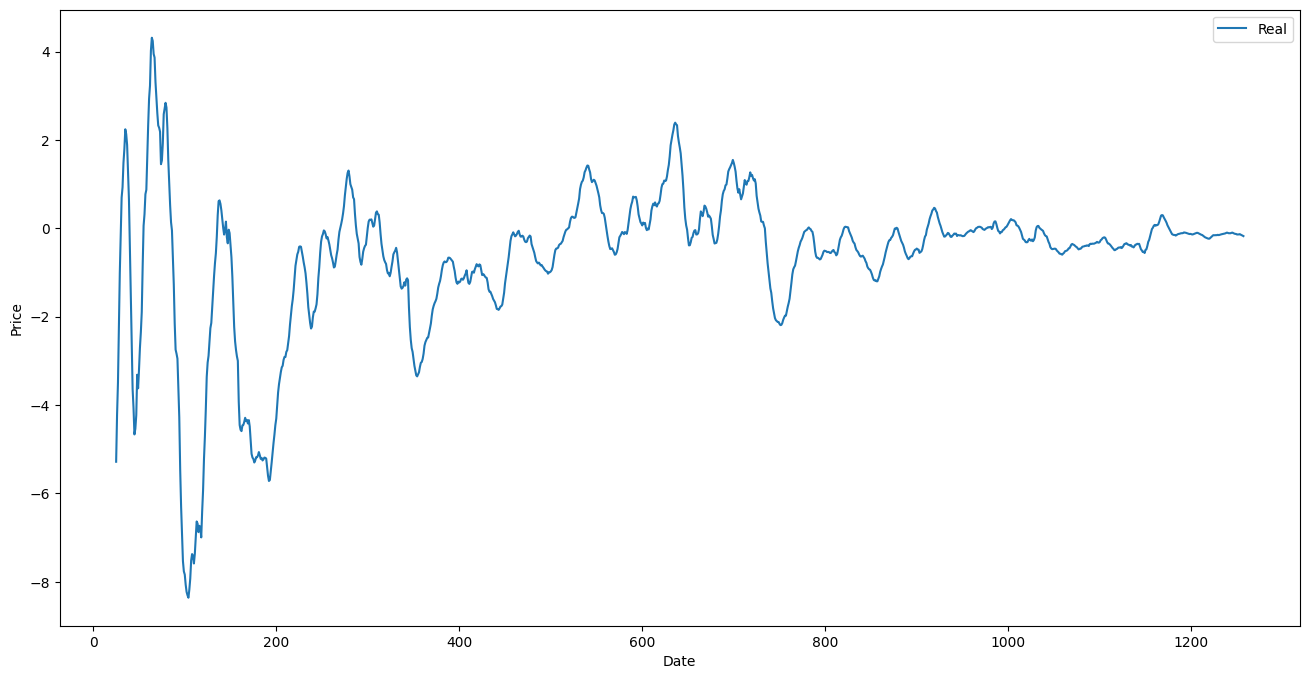

In [7]:
plt.figure(figsize=(16,8))
plt.plot(base['MACD'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

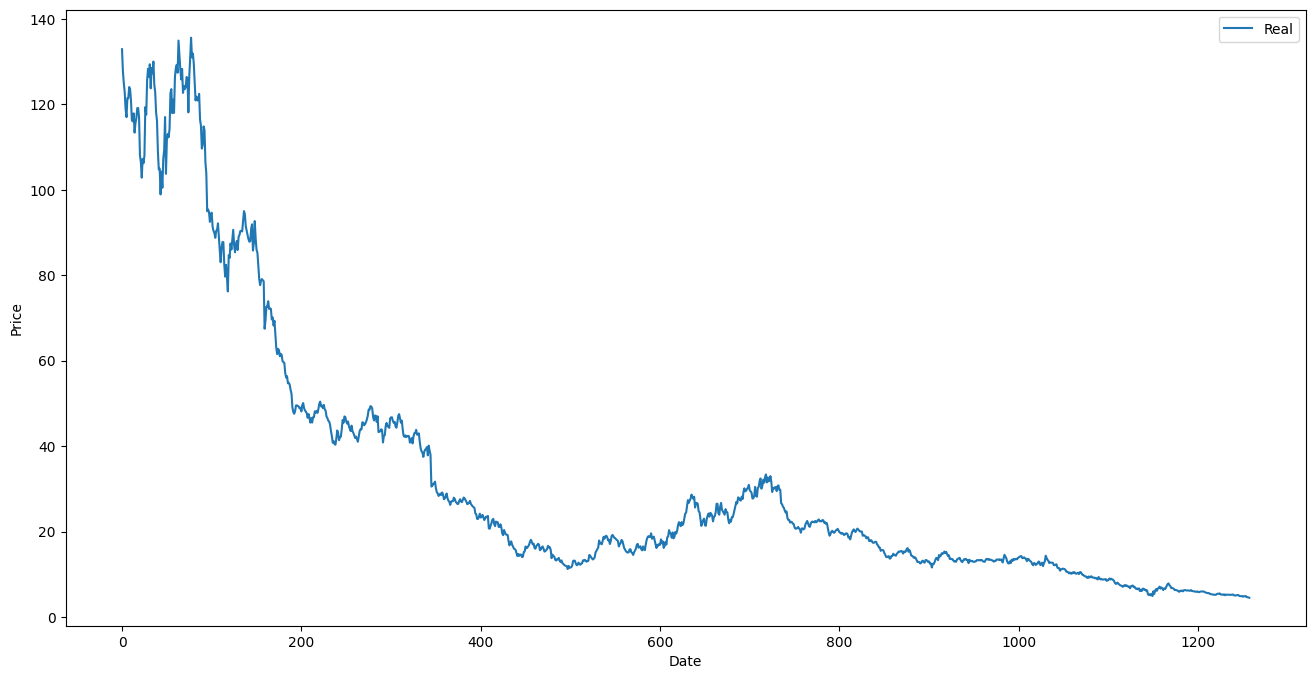

In [8]:
plt.figure(figsize=(16,8))
plt.plot(base['Close/Last'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [9]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base = base.replace([np.inf, -np.inf], np.nan)
base = base.dropna()

In [10]:
# Normalizing the data of real values
scaler_real_value = MinMaxScaler(feature_range=(0, 1))
scaled_data_real_value = scaler_real_value.fit_transform(np.array(base['Close/Last']).reshape(-1, 1))

In [11]:
window_size_real_value = 10
forecasters_real_value = []
real_value_of_prices = []
for i in range(window_size_real_value, len(base)):
    forecasters_real_value.append(scaled_data_real_value[i - window_size_real_value:i, 0])
    real_value_of_prices.append(scaled_data_real_value[i, 0])

forecasters_real_value, real_value_of_prices = np.array(forecasters_real_value), np.array(real_value_of_prices)
forecasters_real_value = np.reshape(forecasters_real_value, (forecasters_real_value.shape[0], forecasters_real_value.shape[1], 1))

In [12]:
#dividindo a coluna close/last em 70% treino e 30% teste com trai_test_split
Xtrain_real_lstm, Xtest_real_lstm, ytrain_real_lstm, ytest_real_lstm = train_test_split(forecasters_real_value, real_value_of_prices,
                                                                                        test_size = 0.3, shuffle = False)

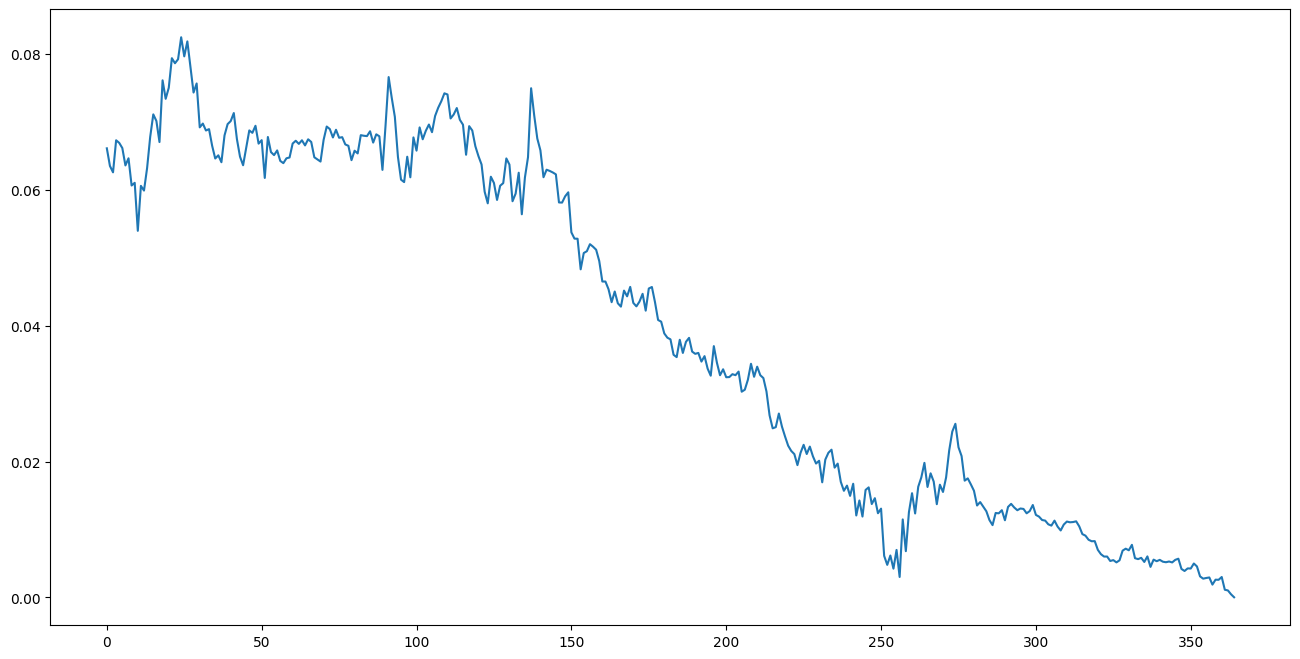

In [13]:
#plotando grafico dos valores de teste
plt.figure(figsize=(16,8))
plt.plot(ytest_real_lstm)
plt.show()

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(base['MACD']).reshape(-1, 1))

In [15]:
window_size = 10
forecasters = []
real_value = []
for i in range(window_size, len(base)):
    forecasters.append(scaled_data[i - window_size:i, 0])
    real_value.append(scaled_data[i, 0])

forecasters, real_value = np.array(forecasters), np.array(real_value)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))

In [16]:
# Separating data between training and testing
X_train, X_test, y_train, y_test = train_test_split(forecasters, real_value, test_size=0.3, shuffle=False)

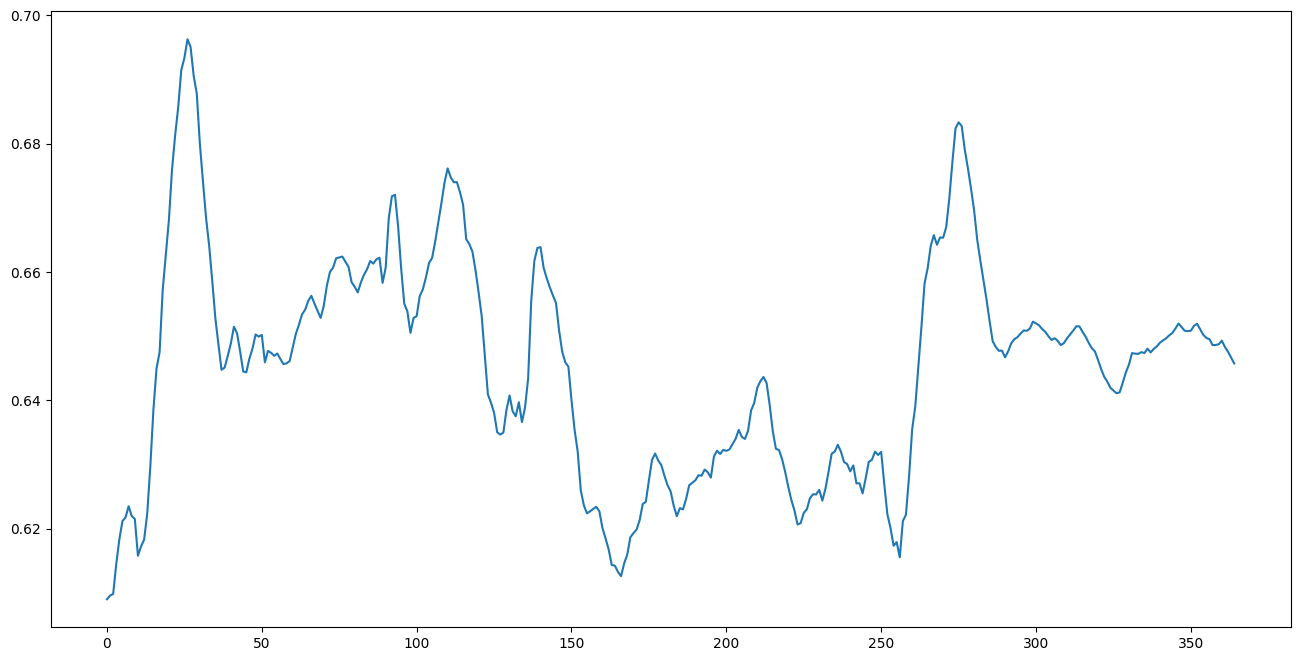

In [17]:
# Showing test set in graph
plt.figure(figsize=(16, 8))
plt.plot(y_test)
plt.show()

In [18]:
# LSTM model

lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(forecasters.shape[1], 1)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.1658 - mean_absolute_error: 0.3397 - val_loss: 0.0022 - val_mean_absolute_error: 0.0452
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0148 - mean_absolute_error: 0.0926 - val_loss: 1.8378e-04 - val_mean_absolute_error: 0.0113
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0132 - mean_absolute_error: 0.0910 - val_loss: 0.0015 - val_mean_absolute_error: 0.0375
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0135 - mean_absolute_error: 0.0885 - val_loss: 1.3212e-04 - val_mean_absolute_error: 0.0082
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0126 - mean_absolute_error: 0.0865 - val_loss: 0.0012 - val_mean_absolute_error: 0.0328
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0125 - mean_absolute_error: 0.0841 - val_loss: 1.3507e-04 - val_mean_absolute_error: 0.0082
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0124 - mean_absolute_error

In [20]:
test_predictions = lstm.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [21]:
# Transforming test values ​​back to original values
y_orig_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#escalonando valores de teste
ytest_real_lstm = scaler_real_value.inverse_transform(ytest_real_lstm.reshape(-1, 1))

In [22]:
test_predictions = test_predictions.ravel()  # Converts to 1D
y_orig_test = y_orig_test.ravel()
ytest_real_lstm = ytest_real_lstm.ravel()

In [23]:
test_size_L = len(y_test)

close_test_L = base['Close/Last'].tail(test_size_L)

In [24]:
# Inverse MACD formula
def MACD_inverse(macd_values, close_values, short_window=12, long_window=26):
    original_prices = []
    for i in range(len(macd_values)):
        if i < long_window:
            original_prices.append(close_values[i])
            continue
        # Calculate moving averages
        short_ma = np.mean(close_values[max(0, i-short_window):i+1]) # Average of the last 'short_window' prices
        long_ma = np.mean(close_values[max(0, i-long_window):i+1])  # Average of the last 'long_window' prices
        # Estimate adjusted price
        estimated_price = close_values[i]
        price_adjustment = (macd_values[i] / 100) * (short_ma - long_ma)  # Estimate adjusted price
        estimated_price += price_adjustment
        original_prices.append(estimated_price)
    return np.array(original_prices)

# Making sure the data is in array format
close_test_L = close_test_L.values if isinstance(close_test_L, pd.Series) else close_test_L

In [25]:
# Inverting the values ​​test_predictions and y_orig_teste by the inverse MACD formula
test_predictions_inverted = MACD_inverse(test_predictions, close_test_L)
y_orig_test_inverted = MACD_inverse(y_orig_test, close_test_L)

min_length = min(len(ytest_real_lstm), len(test_predictions_inverted))
ytest_real_lstm = ytest_real_lstm[:min_length]
test_predictions_inverted = test_predictions_inverted[:min_length]

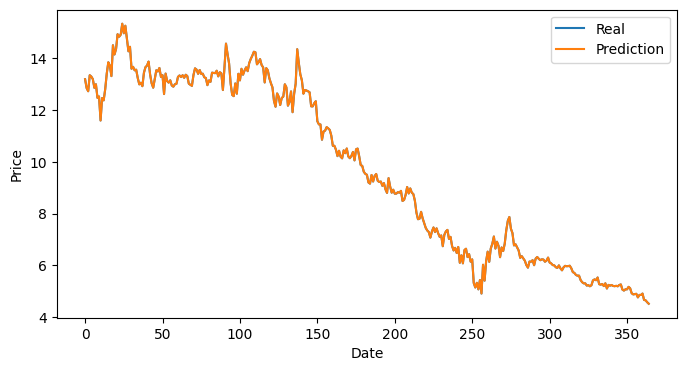

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(ytest_real_lstm)), ytest_real_lstm, label='Real')
plt.plot(range(len(test_predictions_inverted)), test_predictions_inverted, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
# R2 Score
r2 = r2_score(ytest_real_lstm, test_predictions_inverted)
print(f'R2 Score: {r2}')

# RMSE
rmse = np.sqrt(np.mean((ytest_real_lstm - test_predictions_inverted) ** 2))
print(f'RMSE: {rmse}')

R2 Score: 0.9999997939359899
RMSE: 0.001528075004167045


**ARIMA**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator
from math import sqrt

In [30]:
base_A = pd.read_csv('NVDA 5Y.csv')
base_A.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$132.89,285722500,$130.26,$133.48,$129.42
1,10/07/2024,$127.72,346250200,$124.99,$130.64,$124.95
2,10/04/2024,$124.92,244465600,$124.94,$125.04,$121.83
3,10/03/2024,$122.85,277118000,$120.92,$124.36,$120.3401
4,10/02/2024,$118.85,221845900,$116.44,$119.38,$115.14


In [31]:
base_A.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [32]:
# Removing $
base_A['Close/Last'] = base_A['Close/Last'].str.replace('$', '')
base_A['Open'] = base_A['Open'].str.replace('$', '')
base_A['High'] = base_A['High'].str.replace('$', '')
base_A['Low'] = base_A['Low'].str.replace('$', '')

# Converting str to float
base_A['Close/Last'] = base_A['Close/Last'].astype(float)
base_A['Open'] = base_A['Open'].astype(float)
base_A['High'] = base_A['High'].astype(float)
base_A['Low'] = base_A['Low'].astype(float)

In [33]:
cci = CCIIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'], window=20, constant=0.015)
base_A['CCI'] = cci.cci()

sma_tp = base_A['High'] + base_A['Low'] + base_A['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base_A['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base_A['Close/Last'], window=14)
base_A['RSI'] = rsi.rsi()

macd = MACD(close=base_A['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base_A['MACD'] = macd.macd()
base_A['MACD_Signal'] = macd.macd_signal()
base_A['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'])
base_A['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base_A['Close/Last'], window=20, window_dev=2)
base_A['Bollinger_High'] = bollinger.bollinger_hband()
base_A['Bollinger_Low'] = bollinger.bollinger_lband()
base_A['Bollinger_Middle'] = bollinger.bollinger_mavg()
base_A['Bollinger_Width'] = bollinger.bollinger_wband()

base_A.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.5000,257883600,127.3150,129.3500,126.6600,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.932500,27.960967
34,08/20/2024,127.2500,300087400,128.4000,129.8800,125.8900,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.626500,28.657628
35,08/19/2024,130.0000,318333600,124.2800,130.0000,123.4200,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.347000,29.840264
36,08/16/2024,124.5800,302589900,121.9400,125.0000,121.1800,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.737000,30.058729
37,08/15/2024,122.8600,318086700,118.7600,123.2400,117.4700,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.925000,30.163121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,4.9093,667985200,4.7540,4.9823,4.7400,-81.288448,39.738294,-0.131057,-0.128466,-0.002591,4.993934,5.343533,4.736087,5.039810,12.052969
1254,10/14/2019,4.6633,210335760,4.6410,4.6843,4.6096,-167.078542,30.794457,-0.143643,-0.131501,-0.012142,4.980500,5.347782,4.677718,5.012750,13.367186
1255,10/11/2019,4.6498,450866800,4.6603,4.7335,4.6413,-137.142137,30.390224,-0.152944,-0.135790,-0.017154,4.982300,5.344708,4.626322,4.985515,14.409444
1256,10/10/2019,4.5758,327515560,4.5155,4.6270,4.5103,-162.944078,28.204663,-0.164391,-0.141510,-0.022881,4.937576,5.339425,4.568335,4.953880,15.565376


In [34]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base_A = base_A.replace([np.inf, -np.inf], np.nan)
base_A = base_A.dropna()

In [35]:
base_A.head()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.50,257883600,127.315,129.35,126.66,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.9325,27.960967
34,08/20/2024,127.25,300087400,128.400,129.88,125.89,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.6265,28.657628
35,08/19/2024,130.00,318333600,124.280,130.00,123.42,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.3470,29.840264
36,08/16/2024,124.58,302589900,121.940,125.00,121.18,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.7370,30.058729
37,08/15/2024,122.86,318086700,118.760,123.24,117.47,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.9250,30.163121


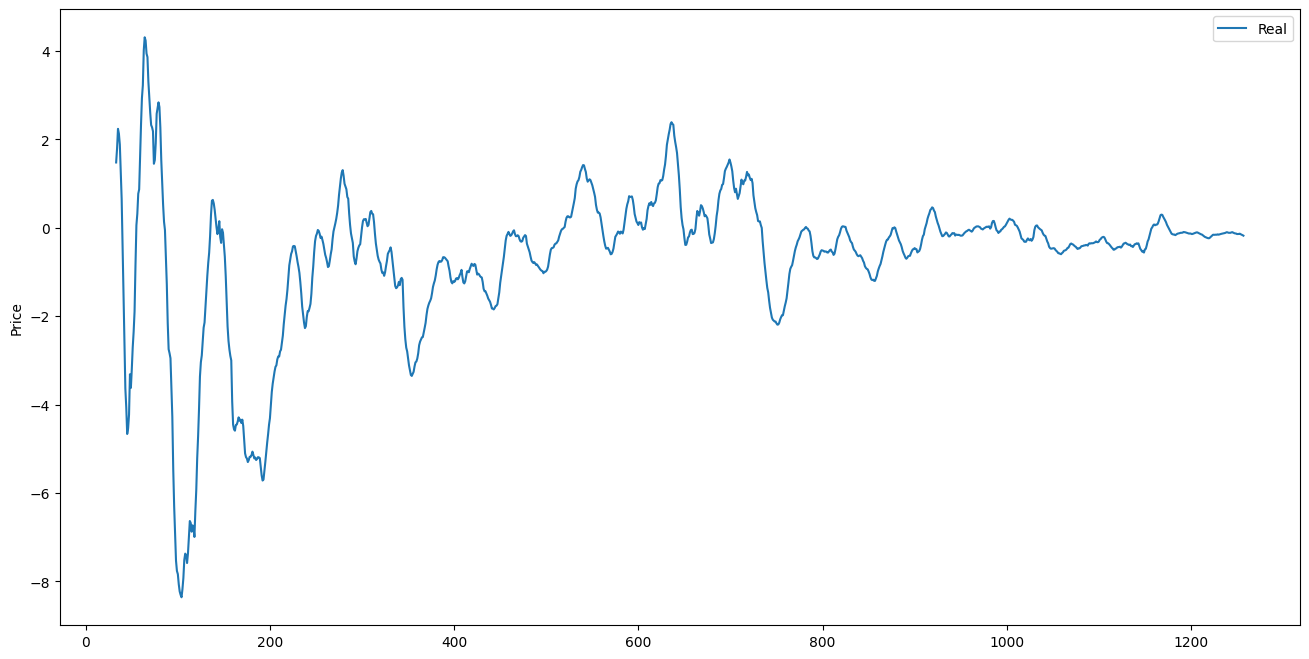

In [36]:
# Plotting MACD
plt.figure(figsize=(16,8))
plt.plot(base_A['MACD'], label='Real')
plt.ylabel('Price')
plt.legend()

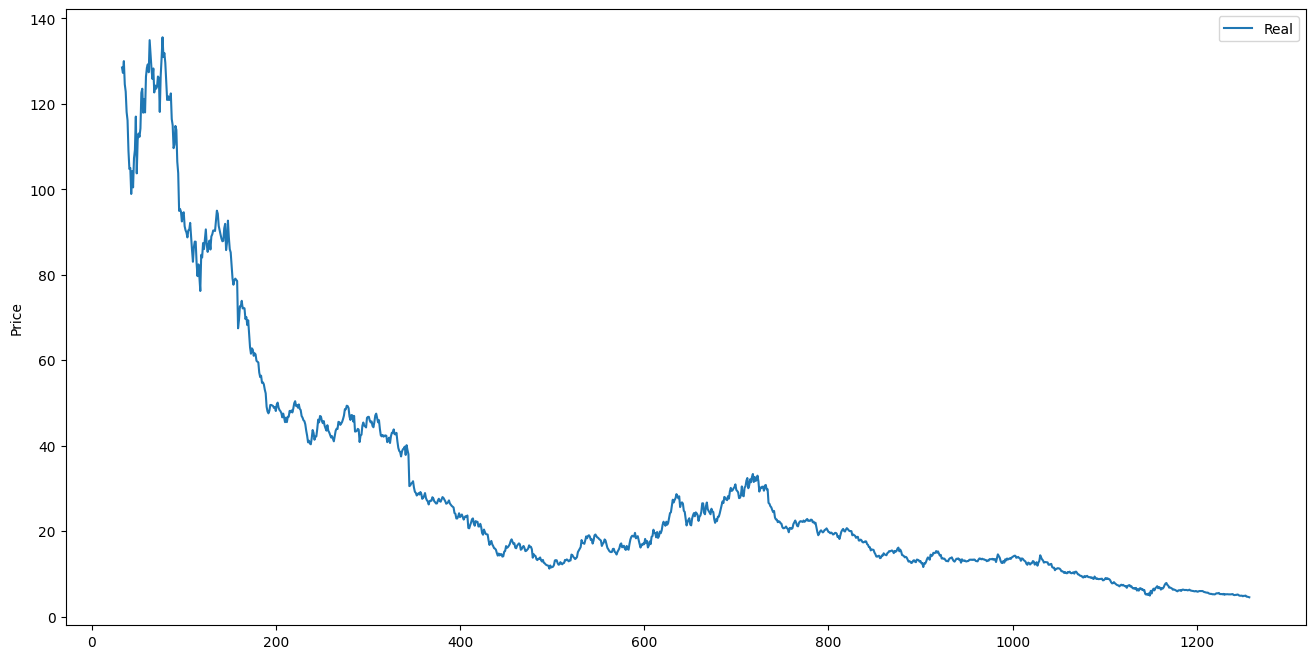

In [37]:
plt.figure(figsize=(16,8))
plt.plot(base_A['Close/Last'], label='Real')
plt.ylabel('Price')
plt.legend()

In [38]:
X_R = base_A['Close/Last'].values
size_R = int(len(X_R) * 0.70)
train_R, test_R = X_R[0:size_R], X_R[size_R:len(X_R)]
history_R = [x_r for x_r in train_R]
forecasts_R = list()

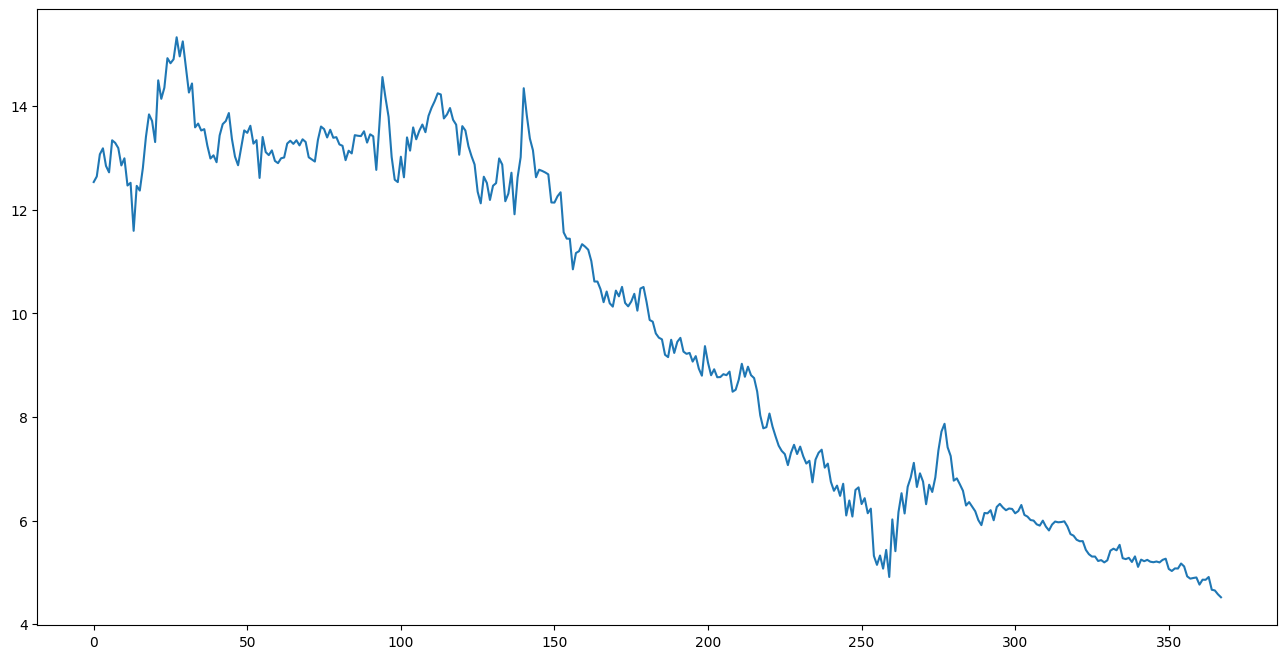

In [39]:
#Test Grafic
plt.figure(figsize=(16, 8))
plt.plot(test_R)
plt.show()

In [40]:
#Addfuller for MACD
result = adfuller(base_A['MACD'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.151466374698205
p-value: 1.10361431400111e-05


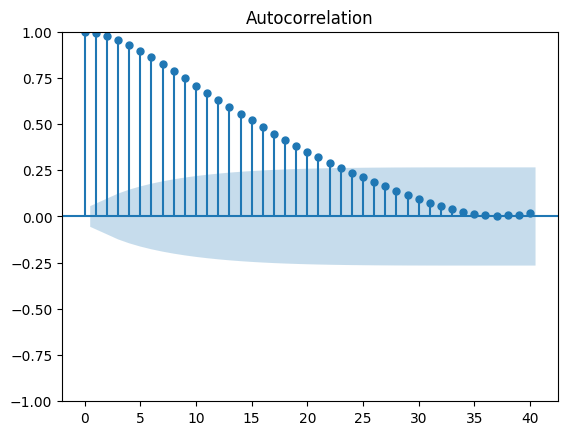

In [41]:
plot_acf(base_A['MACD'], lags=40)
plt.show()

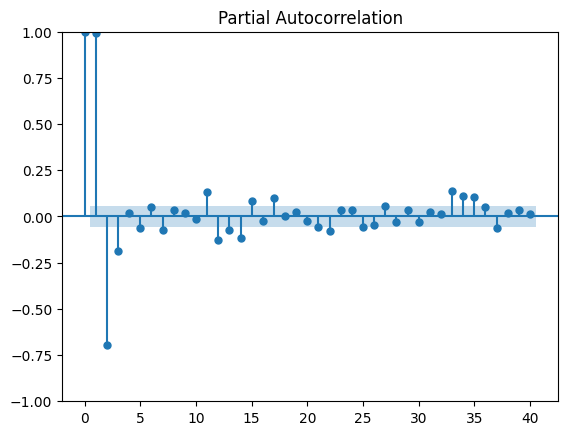

In [42]:
plot_pacf(base_A['MACD'], lags=40)
plt.show()

In [43]:
X = base_A['MACD'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
forecasts = list()

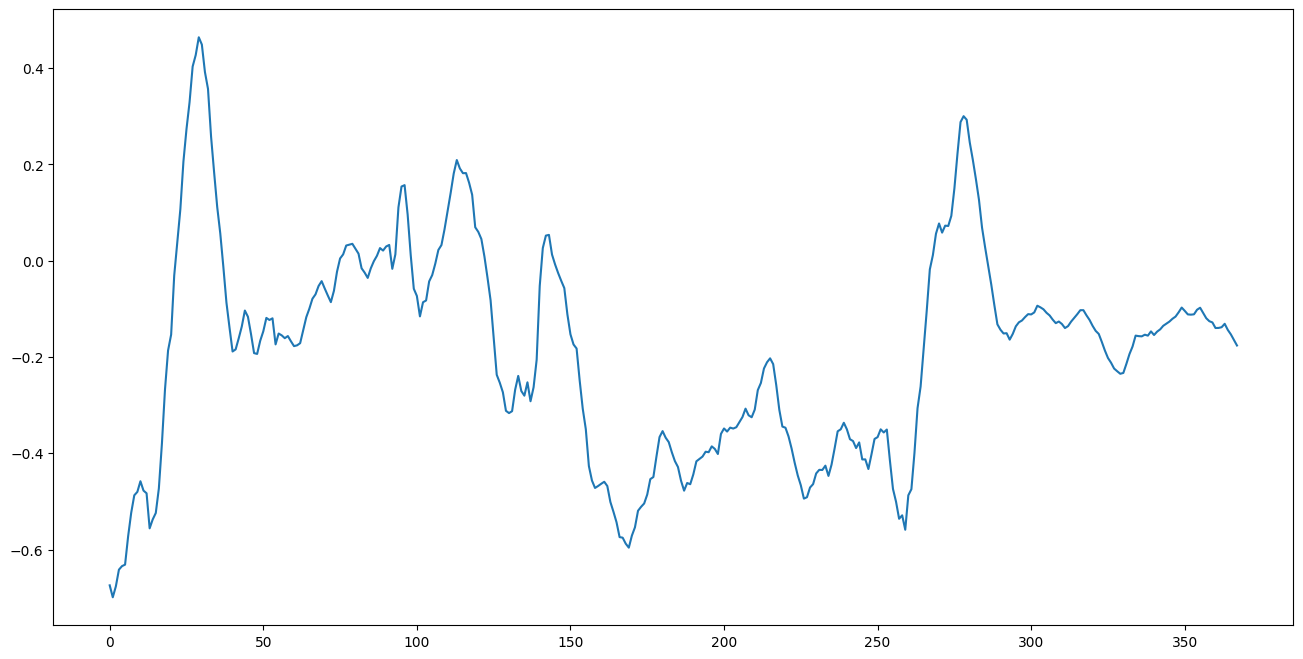

In [44]:
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.show()

In [45]:
# ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Expected={yhat}, Observed={obs}')

Expected=-0.6553776206481352, Observed=-0.6743493770844697
Expected=-0.7153366236585941, Observed=-0.6991355757771291
Expected=-0.7199621352122456, Observed=-0.6764611095018385
Expected=-0.6611206464644397, Observed=-0.6417735805453937
Expected=-0.6142348291706957, Observed=-0.6344454757442417
Expected=-0.6273336463173769, Observed=-0.6313098326579354
Expected=-0.6296064926071182, Observed=-0.5722957552238448
Expected=-0.5300920292338962, Observed=-0.5235263697102539
Expected=-0.48263205018553695, Observed=-0.487327832687237
Expected=-0.4606683626967748, Observed=-0.48016114034513535
Expected=-0.47160907288834225, Observed=-0.4581056276515181
Expected=-0.444224496806367, Observed=-0.4775013869069298
Expected=-0.48731748825228904, Observed=-0.48310773519072114
Expected=-0.49209009115836644, Observed=-0.5559433899977861
Expected=-0.6042317678177745, Observed=-0.5374147048466522
Expected=-0.5352879095771819, Observed=-0.5240487583054882
Expected=-0.5047235004143876, Observed=-0.4729438285

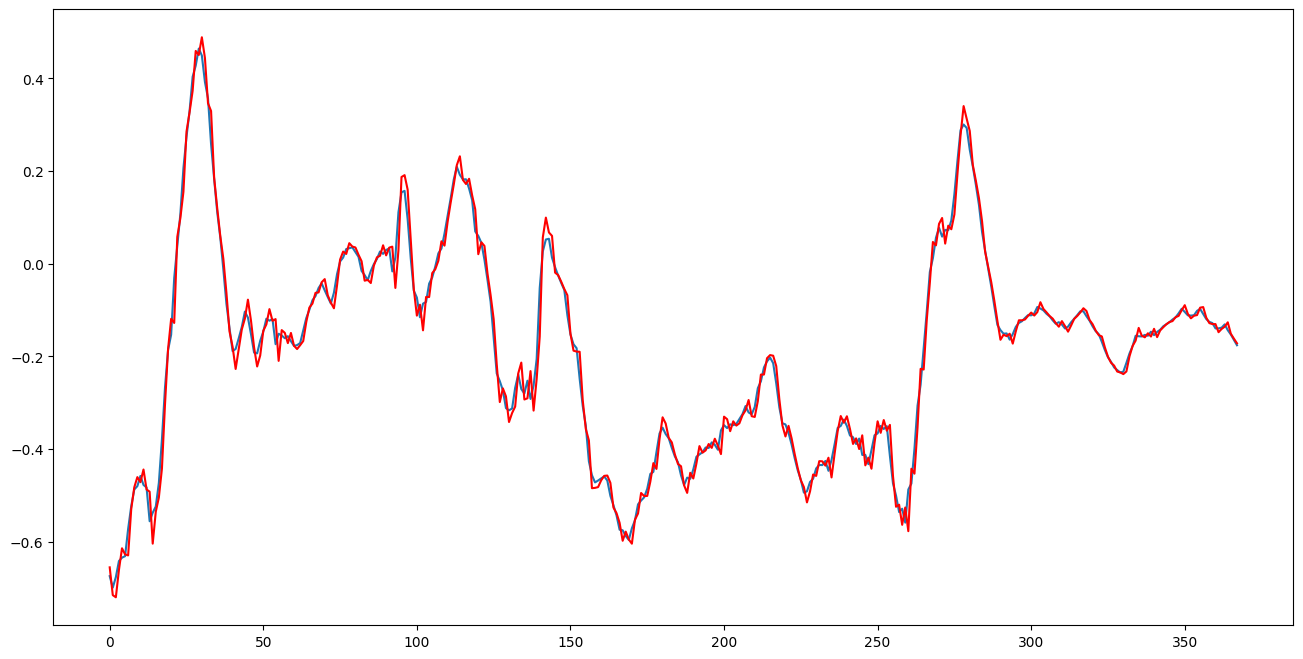

In [46]:
# Test and forecast set
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.plot(forecasts, color='red')
plt.show()

In [47]:
# Ensuring that data is one-dimensional
test = test.ravel()
forecasts = np.array(forecasts).ravel()

In [48]:
# Getting the high, low and close values ​​from the test set for the MACD
test_size_A = len(test)

close_test_A = base_A['Close/Last'].tail(test_size_A)

In [49]:
print(test.shape)
print(forecasts.shape)

(368,)
(368,)


In [50]:
# Inverse MACD formula
def MACD_inverse_A(macd_values_A, close_values_A, short_window=12, long_window=26):
    original_prices = []
    for i in range(len(macd_values_A)):
        if i < long_window:
            original_prices.append(close_values_A[i])
            continue
        # Calculate moving averages
        short_ma = np.mean(close_values_A[max(0, i-short_window):i+1]) # Average of the last 'short_window' prices
        long_ma = np.mean(close_values_A[max(0, i-long_window):i+1])  # Average of the last 'long_window' prices
        # Estimate adjusted price
        estimated_price = close_values_A[i]
        price_adjustment = (macd_values_A[i] / 100) * (short_ma - long_ma) # Adjust based on difference
        estimated_price += price_adjustment
        original_prices.append(estimated_price)
    return np.array(original_prices)

# Making sure the data is in array format
close_test_A = close_test_A.values if isinstance(close_test_A, pd.Series) else close_test_A

In [51]:
test_inverted = MACD_inverse_A(test, close_test_A)
forecasts_inverted = MACD_inverse_A(forecasts, close_test_A)

min_length_R = min(len(test_R), len(forecasts_inverted))
test_R = test_R[:min_length_R]
forecasts_inverted = forecasts_inverted[:min_length_R]

In [52]:
# RMSE
rmse = sqrt(mean_squared_error(test_R, forecasts_inverted))
print(f'RMSE: {rmse}')

# R2 Score
r2 = r2_score(test_R, forecasts_inverted)
print(f'R2 Score: {r2}')

RMSE: 0.001367130658134985
R2 Score: 0.9999998348181837


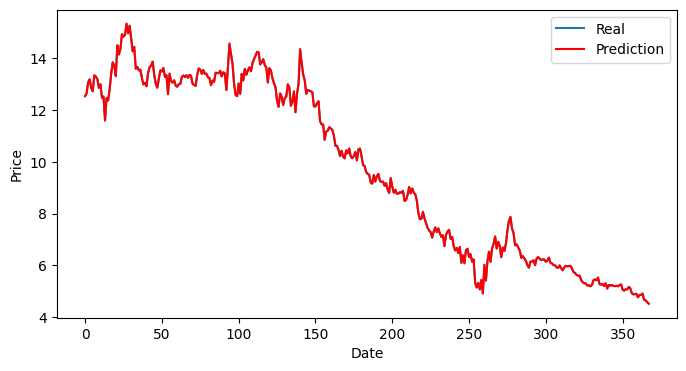

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_R)), test_R, label='Real')
plt.plot(range(len(forecasts_inverted)), forecasts_inverted, label='Prediction', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()